In [1]:
import tensorflow as tf

# Define the directory containing the images
directory = 'dataset'

# Specify the class names
class_names = ['Bacterialblight', 'Blast', 'Brownspot',"Healthy","Tungro"]
num_classes = tf.io.gfile.listdir(directory)
# Create a dataset using the images in the directory
train,test = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=16,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='both',
    class_names=class_names
)


Found 8164 files belonging to 5 classes.
Using 5715 files for training.
Using 2449 files for validation.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Input, Dense, BatchNormalization, Activation, 
    Add, Multiply, Reshape, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def channel_attention_block(input_layer):
    """
    Channel attention mechanism similar to SENet
    """
    avg_pool = GlobalAveragePooling2D()(input_layer)
    max_pool = GlobalMaxPooling2D()(input_layer)
    
    # Shared MLP for channel attention
    channels = input_layer.shape[-1]
    avg_dense = Dense(channels // 8, activation='relu')(avg_pool)
    avg_dense = Dense(channels, activation='sigmoid')(avg_dense)
    max_dense = Dense(channels // 8, activation='relu')(max_pool)
    max_dense = Dense(channels, activation='sigmoid')(max_dense)
    
    # Combine and reshape channel weights
    scale = Add()([avg_dense, max_dense])
    scale = Reshape((1, 1, channels))(scale)
    
    # Apply channel-wise attention
    return Multiply()([input_layer, scale])

def cam_model(input_shape=(64, 64, 3), num_classes=5):

    # Input layer
    inputs = Input(shape=input_shape)
    
    # First convolutional block
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = channel_attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Second convolutional block
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = channel_attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Third convolutional block
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = channel_attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    # Fourth convolutional block (for feature extraction)
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Global Average Pooling and classification layers
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers with increased dropout and regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    
    # Output layer for class prediction
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def create_data_augmentation():

    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def build_model(input_shape=(64, 64, 3), num_classes=5):

    # Create the model
    model = cam_model(input_shape, num_classes)
    
    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    return model, [early_stopping, reduce_lr]

In [3]:

# Load the model from the HDF5 file
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime
loaded_model,callbacks = build_model()

#loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the TensorBoard callback
epochs = 50
history=loaded_model.fit(train,
          epochs=epochs,
          validation_data=test,
          callbacks=[tensorboard_callback])



Epoch 1/50
358/358 [==============================] - 927s 3s/step - loss: 1.9594 - accuracy: 0.5650 - val_loss: 1.5700 - val_accuracy: 0.6309
Epoch 2/50
358/358 [==============================] - 995s 3s/step - loss: 1.3045 - accuracy: 0.6992 - val_loss: 2.1605 - val_accuracy: 0.5394
Epoch 3/50
358/358 [==============================] - 876s 2s/step - loss: 1.0913 - accuracy: 0.7384 - val_loss: 1.0174 - val_accuracy: 0.7534
Epoch 4/50
358/358 [==============================] - 783s 2s/step - loss: 1.0446 - accuracy: 0.7475 - val_loss: 1.0482 - val_accuracy: 0.7240
Epoch 5/50
358/358 [==============================] - 916s 3s/step - loss: 0.9592 - accuracy: 0.7822 - val_loss: 0.8756 - val_accuracy: 0.7832
Epoch 6/50
358/358 [==============================] - 949s 3s/step - loss: 0.8975 - accuracy: 0.7976 - val_loss: 0.8229 - val_accuracy: 0.7783
Epoch 7/50
358/358 [==============================] - 884s 2s/step - loss: 0.8337 - accuracy: 0.8089 - val_loss: 2.7777 - val_accuracy: 0.4986

KeyboardInterrupt: 

In [4]:
loaded_model.save('my_model2.h5')

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
model = load_model('my_model2.h5')
loss, accuracy = model.evaluate(test)

# Print the accuracy
print(f'Test accuracy: {accuracy*100:.2f}%')


154/154 [==============================] - 43s 219ms/step - loss: 0.5736 - accuracy: 0.8746
Test accuracy: 87.46%


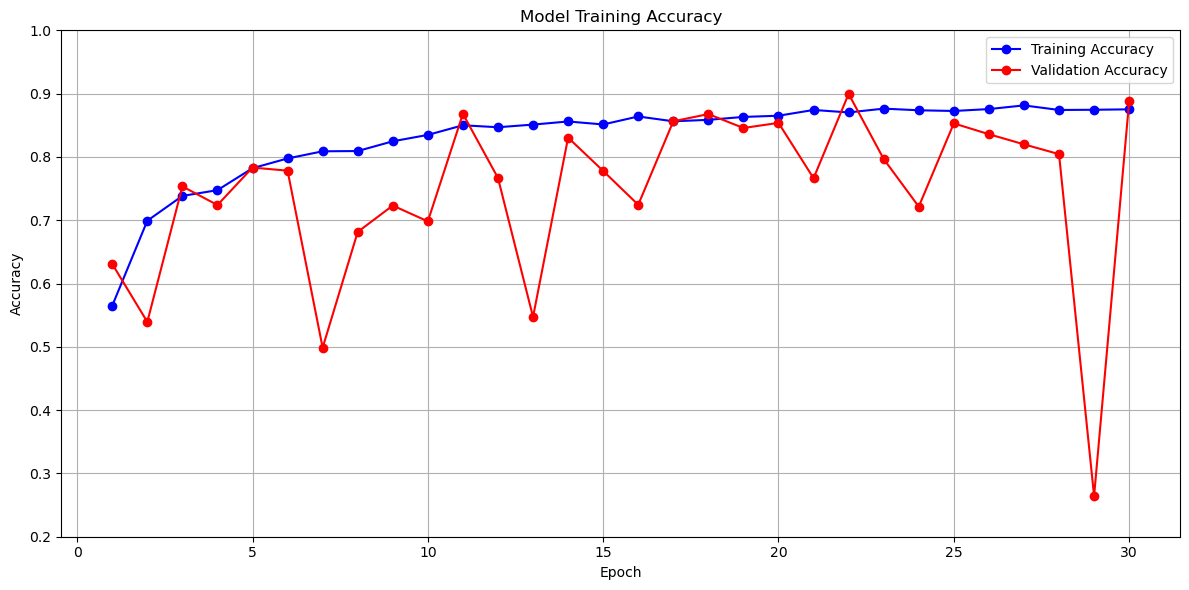

Max Training Accuracy: 0.8814
Max Validation Accuracy: 0.8996
Final Training Accuracy: 0.8752
Final Validation Accuracy: 0.8880


<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

# Extracted accuracy values
epochs = list(range(1, 31))
train_accuracy = [
    0.5650, 0.6992, 0.7384, 0.7475, 0.7822, 0.7976, 0.8089, 0.8093, 0.8247, 0.8348,
    0.8500, 0.8469, 0.8511, 0.8560, 0.8513, 0.8639, 0.8563, 0.8586, 0.8632, 0.8651,
    0.8742, 0.8703, 0.8763, 0.8737, 0.8726, 0.8756, 0.8814, 0.8742, 0.8745, 0.8752
]
val_accuracy = [
    0.6309, 0.5394, 0.7534, 0.7240, 0.7832, 0.7783, 0.4986, 0.6815, 0.7232, 0.6982,
    0.8681, 0.7668, 0.5472, 0.8305, 0.7779, 0.7244, 0.8563, 0.8677, 0.8457, 0.8538,
    0.7664, 0.8996, 0.7967, 0.7215, 0.8530, 0.8359, 0.8199, 0.8044, 0.2642, 0.8880
]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('Cam_attention_accuracy.png', dpi=300)

# Print some key statistics
print(f"Max Training Accuracy: {max(train_accuracy):.4f}")
print(f"Max Validation Accuracy: {max(val_accuracy):.4f}")
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")